# Chapter 5, Example 2b
## 3-fold cross-validation to determine the number of hidden neurons

In [1]:
import torch
from torch import nn

from sklearn import datasets
from sklearn.model_selection import KFold

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

In [2]:
lr = 0.1
no_epochs = 100

no_labels = 3
no_features = 4
no_exps = 10
no_folds = 3

hidden_units = [2, 4, 6, 8, 10, 12]

seed = 10
torch.manual_seed(seed)
np.random.seed(seed)

In [3]:
no_inputs = 4
no_outputs = 3

# input data
iris = datasets.load_iris()
iris.data -= np.mean(iris.data, axis=0)

no_data = len(iris.data)

X = iris.data

# convert the targets into one-hot matrix
Y = np.zeros((no_data, no_outputs))
for i in range(no_data):
    Y[i, iris.target[i]] = 1
    
print(np.shape(X))
print(np.shape(Y))

(150, 4)
(150, 3)


In [4]:
class FFN(nn.Module):
    def __init__(self, no_features, hidden_units, no_labels):
        super().__init__()
        self.relu_stack = nn.Sequential(
            nn.Linear(no_features, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, no_labels),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        logits = self.relu_stack(x)
        return logits

In [11]:
def train_exp(rseed):

    cv = KFold(n_splits=no_folds, shuffle=True, random_state=rseed)
    
    acc = []
    for train_idx, test_idx in cv.split(X, Y):
        x_train, y_train  = X[train_idx], Y[train_idx]
        x_test, y_test = X[test_idx], Y[test_idx]

        acc_ = []
        for no_hidden in hidden_units:
        
            model = FFN(no_inputs, no_hidden, no_outputs)
    
            loss_fn = torch.nn.CrossEntropyLoss()
            optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    
            for epoch in range(no_epochs):
                pred = model(torch.tensor(x_train, dtype=torch.float))
                loss = loss_fn(pred, torch.tensor(y_train, dtype=torch.float))
    
                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
    
            pred = model(torch.tensor(x_test, dtype=torch.float))
            acc__ = (pred.argmax(1) == torch.tensor(y_test, dtype=torch.float).argmax(1)).type(torch.float).mean()
    
            acc_.append(acc__.item())

        acc.append(acc_)
    
    cv_acc = np.mean(np.array(acc), axis = 0)
        
    return cv_acc

In [12]:
acc = []
for exp in range(no_exps):
        
    acc.append(train_exp(exp))
    print('exp %d, cv acc %s'%(exp, acc[exp]))

mean_acc = np.mean(np.array(acc), axis = 0)
print('mean accuracy %s'%(mean_acc))
print('* hidden units %d *'%hidden_units[np.argmax(mean_acc)])

exp 0, cv acc [0.60666666 0.66000001 0.68000001 0.74000001 0.72666665 0.72666667]
exp 1, cv acc [0.59333332 0.77333333 0.66666667 0.74666667 0.67333335 0.80000001]
exp 2, cv acc [0.63333335 0.66666667 0.68666667 0.79333335 0.72666665 0.73333333]
exp 3, cv acc [0.74000001 0.73333333 0.71333335 0.84666667 0.72000001 0.78000001]
exp 4, cv acc [0.50000001 0.71333333 0.78000001 0.70000001 0.69999999 0.68666667]
exp 5, cv acc [0.55333333 0.69333335 0.70666665 0.69333335 0.79333333 0.71999999]
exp 6, cv acc [0.64666666 0.78000001 0.74000001 0.64666669 0.76666665 0.72666667]
exp 7, cv acc [0.66666667 0.57999999 0.76000001 0.75333333 0.73333333 0.73999999]
exp 8, cv acc [0.72666667 0.72666665 0.66666667 0.71333333 0.74000001 0.70666669]
exp 9, cv acc [0.57333333 0.66666667 0.75999999 0.70666667 0.72666667 0.70666667]
mean accuracy [0.624      0.69933333 0.716      0.73400001 0.73066666 0.73266667]
* hidden units 8 *


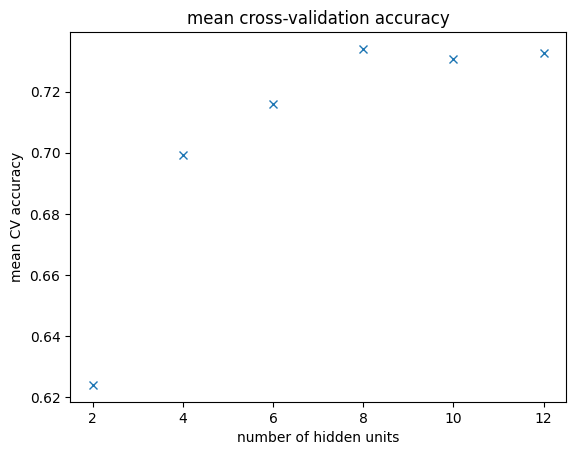

In [13]:
plt.figure(1)
plt.plot(hidden_units, mean_acc, marker = 'x', linestyle = 'None')
plt.title('mean cross-validation accuracy')
plt.xlabel('number of hidden units')
plt.ylabel('mean CV accuracy')
plt.show()